# Car Damage Assessment
Visualize mask predictions on input image.

Output:
- Match detected damage to detected part

In [1]:
import sys

sys.path.insert(0, "C:/Users/I17215834/Box/Projects/car-damage-assessment")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import src.transforms as T
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
from torchvision.io import read_image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_segmentation_masks

## Dataset

In [3]:
root_path = Path().absolute().parents[0]
data_path = root_path / "data"

train_path = data_path / "train"
train_ann_path = train_path / "COCO_train_annos.json"
train_parts_ann_path = train_path / "COCO_mul_train_annos.json"

val_path = data_path / "val"
val_ann_path = val_path / "COCO_val_annos.json"
val_parts_ann_path = val_path / "COCO_mul_val_annos.json"

test_path = data_path / "test"

In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Evaluation

In [5]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

In [6]:
model_path = root_path / "model" / "car-damage-mask-rcnn.pth"
model = get_instance_segmentation_model(num_classes=2)
model.load_state_dict(torch.load(model_path))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

### Predict

In [7]:
# pick one image from the test set
img_path = data_path / "test" / "66.jpg"
img = Image.open(img_path)
img_t, _ = get_transform(train=False)(img, _)

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img_t])

c:\users\i17215834\appdata\local\programs\python\python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
prediction

[{'boxes': tensor([[4.2366e+02, 5.5747e+02, 6.0308e+02, 7.3563e+02],
          [3.0102e+02, 5.1515e+02, 4.0574e+02, 5.9825e+02],
          [3.0632e+02, 5.3425e+02, 7.5788e+02, 7.6666e+02],
          [4.0001e+02, 5.4424e+02, 6.6148e+02, 6.5926e+02],
          [2.8090e+02, 5.0246e+02, 4.1948e+02, 6.3434e+02],
          [2.5369e+02, 4.7999e+02, 7.3870e+02, 6.8842e+02],
          [4.3711e+02, 5.7641e+02, 5.8217e+02, 6.4671e+02],
          [3.9475e+02, 5.6282e+02, 4.3272e+02, 6.0005e+02],
          [2.5714e+02, 4.9791e+02, 6.0261e+02, 8.0995e+02],
          [1.5308e+02, 3.1125e+01, 3.3121e+02, 1.9516e+02],
          [3.9499e+02, 5.6659e+02, 7.3683e+02, 8.8509e+02],
          [6.9394e+02, 3.0970e+02, 8.5566e+02, 4.6674e+02],
          [3.5152e+02, 5.2574e+02, 4.2099e+02, 6.0570e+02],
          [3.7234e+02, 5.3054e+02, 4.0485e+02, 5.9998e+02],
          [2.3944e+02, 7.3259e+02, 2.7067e+02, 7.6365e+02],
          [2.2685e+02, 4.9314e+02, 4.6878e+02, 5.8790e+02],
          [4.7598e+02, 5.5529e+

In [69]:
pred_masks = prediction[0]["masks"]
print(
    f"shape = {pred_masks.shape}, dtype = {pred_masks.dtype}, "
    f"min = {pred_masks.min()}, max = {pred_masks.max()}"
)

shape = torch.Size([64, 1, 1024, 1024]), dtype = torch.float32, min = 0.0, max = 0.9993971586227417


In [77]:
pred_scores = prediction[0]["scores"]
print(
    f"shape = {pred_scores.shape}, dtype = {pred_scores.dtype}, "
    f"min = {pred_scores.min()}, max = {pred_scores.max()}"
)

shape = torch.Size([64]), dtype = torch.float32, min = 0.05068114772439003, max = 0.4427891969680786


In [92]:
type(prediction[0]["scores"].max())

torch.Tensor

Test Image

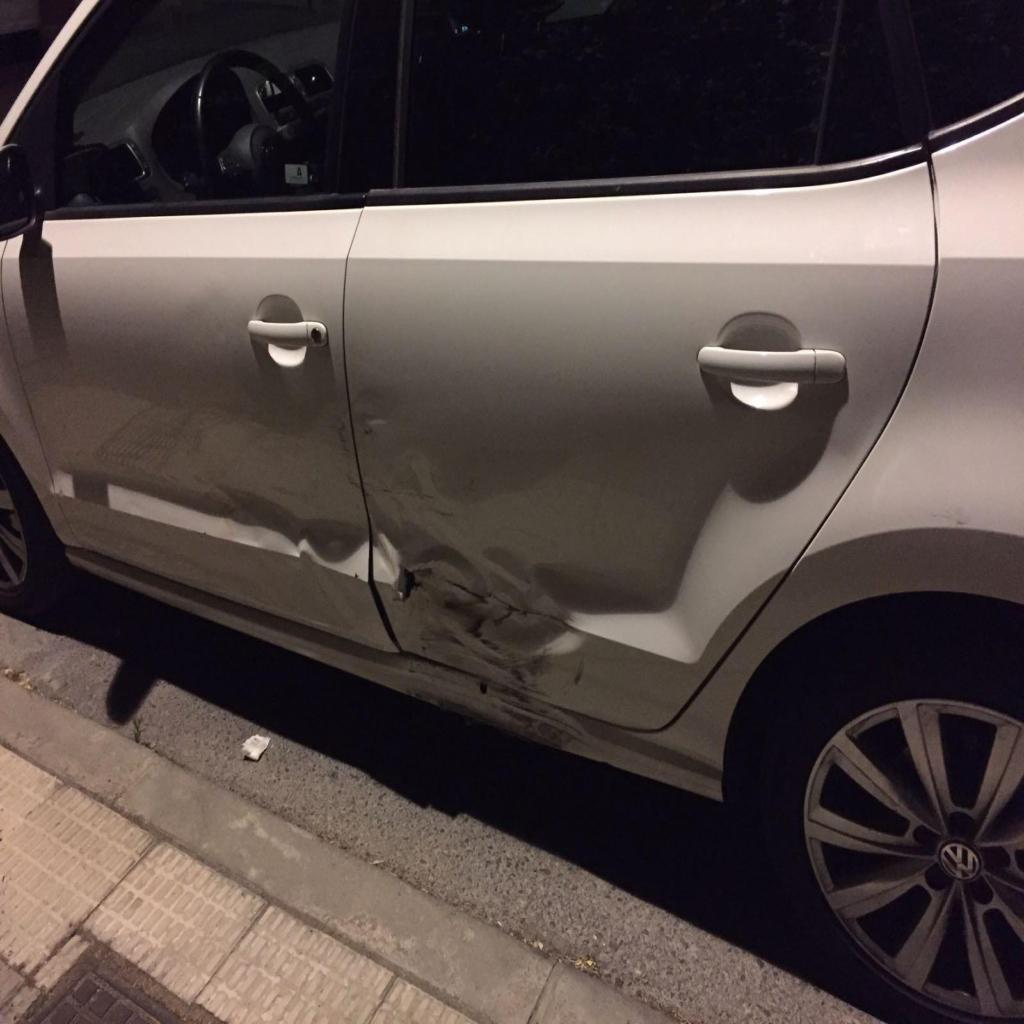

In [9]:
img_o = Image.fromarray(img_t.mul(255).permute(1, 2, 0).byte().numpy())
img_o

Visualizing mask prediction

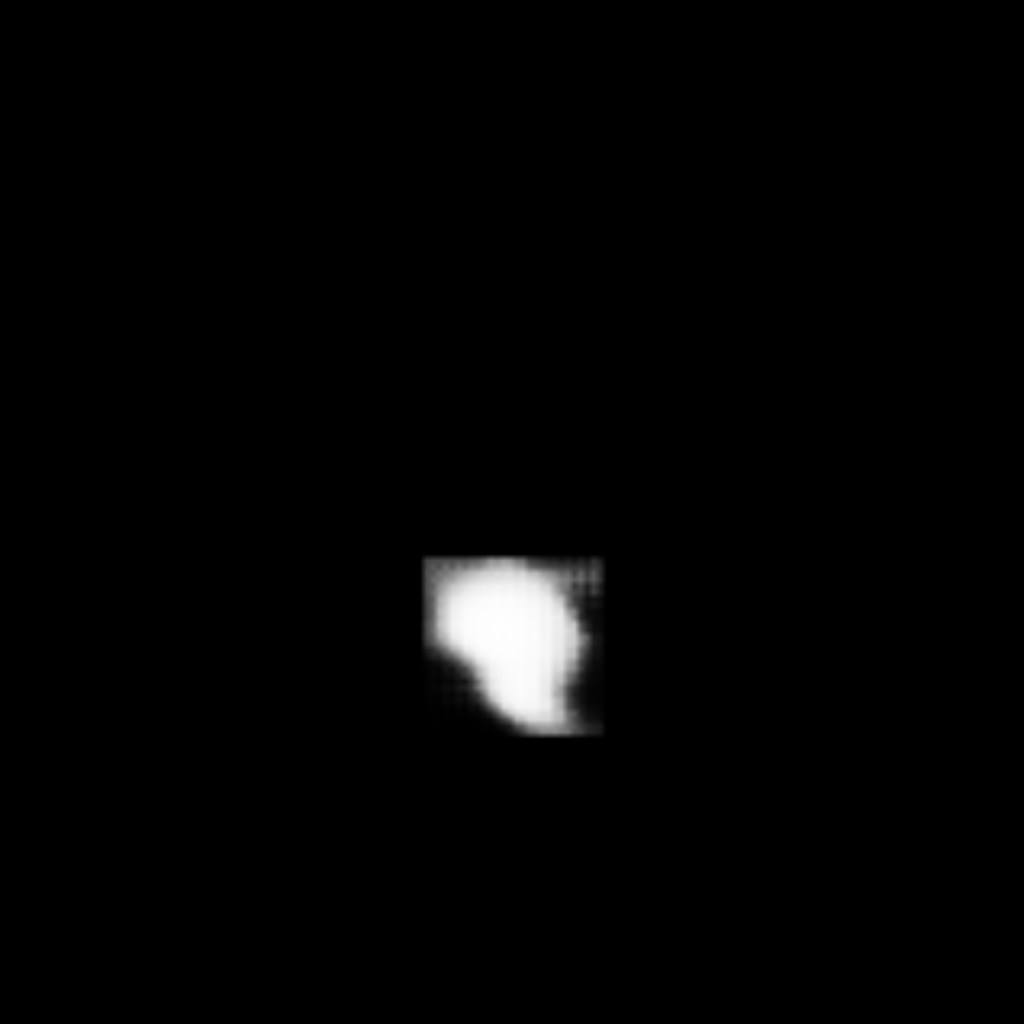

In [10]:
img_p = Image.fromarray(prediction[0]["masks"][0, 0].mul(255).byte().cpu().numpy())
img_p

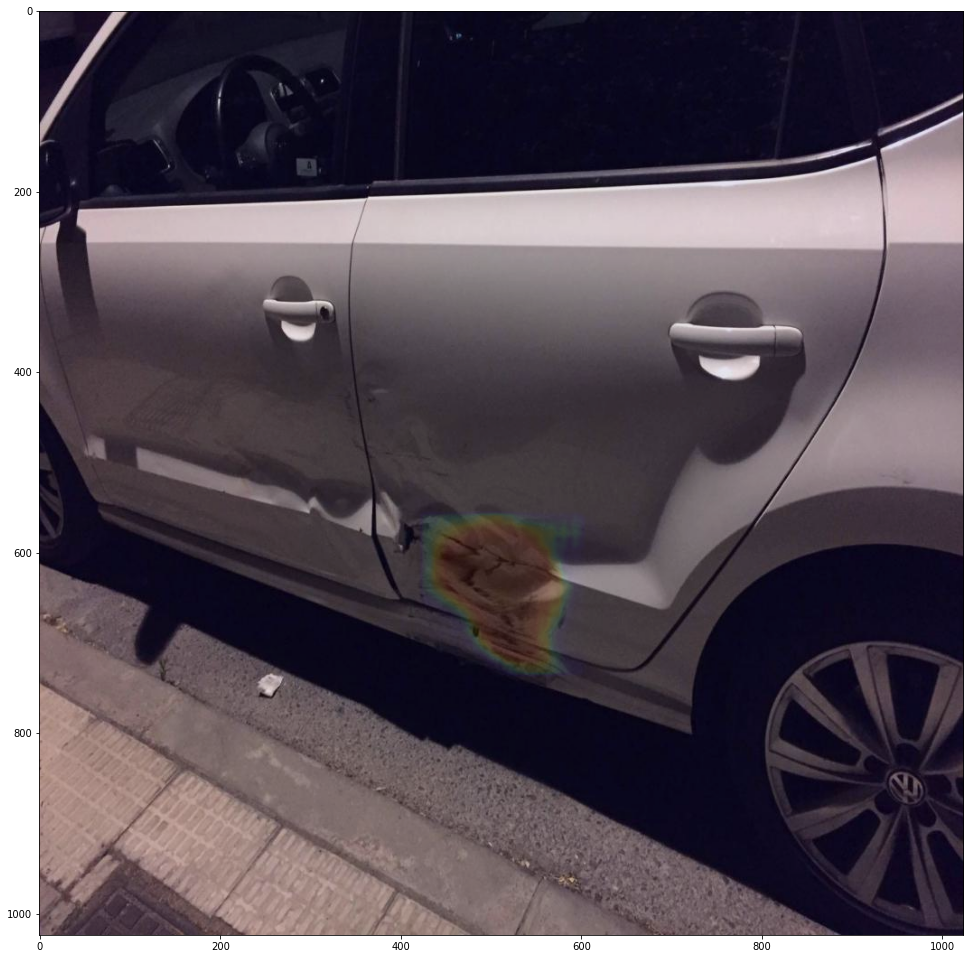

In [11]:
plt.figure(figsize=(17, 17))
plt.imshow(img)
plt.imshow(img_p, cmap="jet", alpha=0.1, interpolation="bilinear")
plt.show()

### Visualize predicted mask on test image

**PyTorch Visualization**

In [12]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize=(17, 17), ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

With threshold

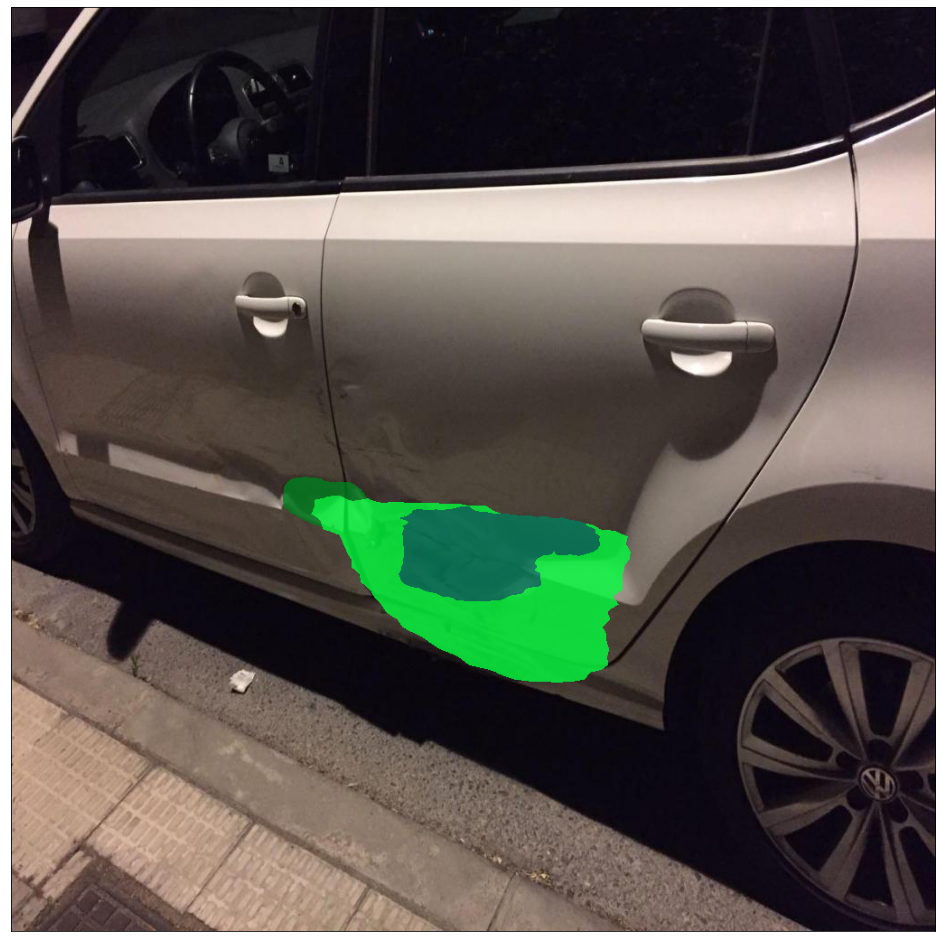

In [89]:
img_int = read_image(str(img_path))

proba_threshold = 0.5
score_threshold = 0.33

boolean_masks = [
    out["masks"][out["scores"] > score_threshold] > proba_threshold
    for out in prediction
]

car_damage_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip([img_int], boolean_masks)
]

show(car_damage_with_masks)

In [91]:
car_damage_with_masks

[tensor([[[ 45,  47,  48,  ...,  16,  19,  21],
          [ 46,  48,  49,  ...,  17,  19,  21],
          [ 48,  49,  51,  ...,  17,  18,  20],
          ...,
          [134, 135, 135,  ...,  20,  21,  22],
          [129, 131, 133,  ...,  21,  22,  22],
          [134, 136, 140,  ...,  23,  23,  22]],
 
         [[ 34,  36,  37,  ...,  10,  13,  15],
          [ 35,  37,  38,  ...,  11,  13,  15],
          [ 37,  38,  40,  ...,  11,  12,  14],
          ...,
          [105, 106, 106,  ...,  12,  13,  14],
          [100, 102, 104,  ...,  13,  14,  14],
          [105, 107, 111,  ...,  15,  15,  14]],
 
         [[ 42,  44,  45,  ...,  24,  27,  29],
          [ 43,  45,  46,  ...,  25,  27,  29],
          [ 45,  46,  48,  ...,  25,  26,  28],
          ...,
          [109, 110, 108,  ...,  25,  26,  27],
          [104, 106, 106,  ...,  26,  27,  27],
          [109, 111, 113,  ...,  28,  28,  27]]], dtype=torch.uint8)]

Without threshold

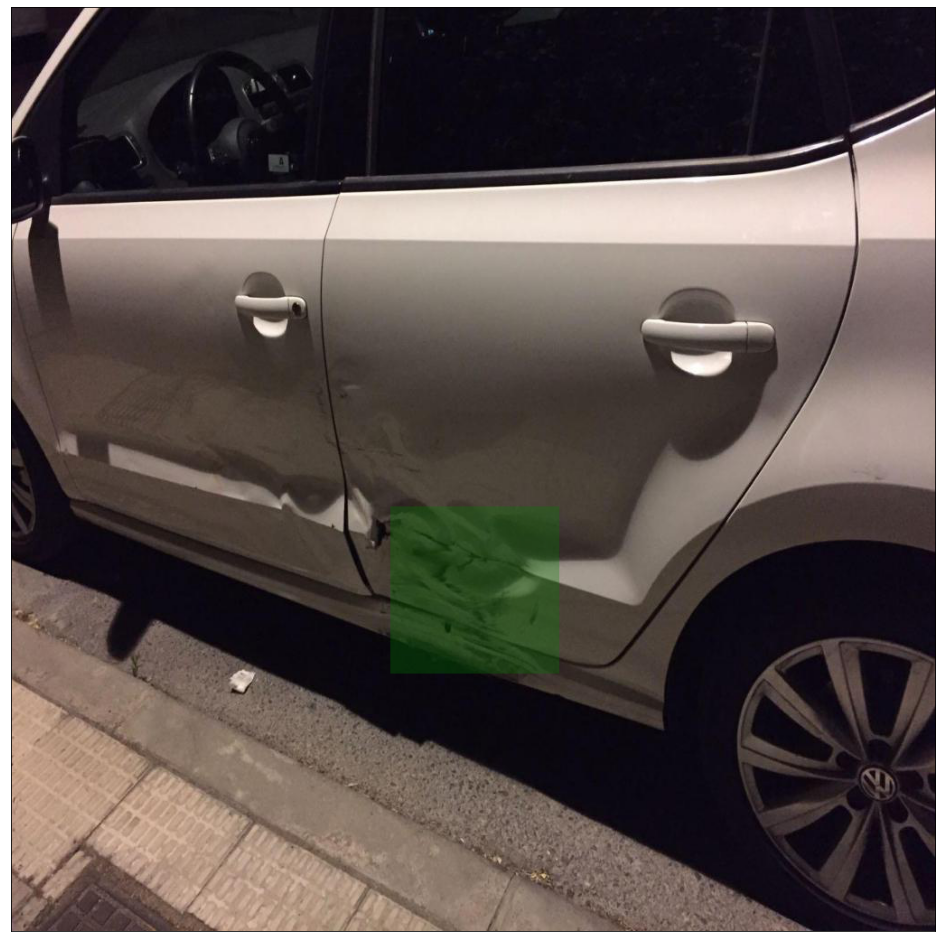

In [90]:
show(
    draw_segmentation_masks(
        img_int, prediction[0]["masks"][0, 0].mul(255).bool(), alpha=0.3, colors="green"
    )
)

#### Visualize bbox and mask contour
https://gist.github.com/fmassa/d802c684512bcc99f54b714f10c96872

In [15]:
from src import visualize as V

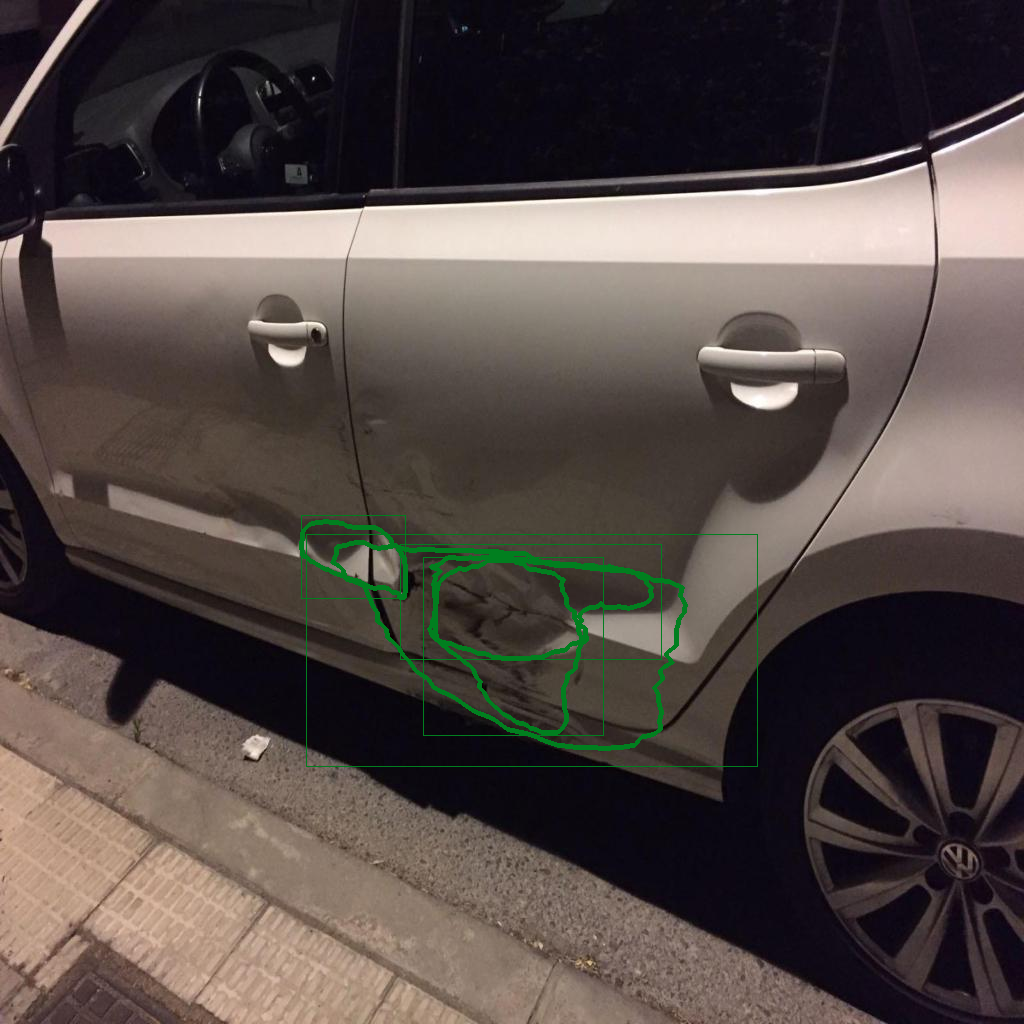

In [79]:
top_predictions = V.select_top_predictions(prediction[0], 0.33)
top_predictions = {k: v.cpu() for k, v in top_predictions.items()}
result = np.array(img).copy()
result = V.overlay_boxes(result, top_predictions)
result = V.overlay_mask(result, top_predictions)
# result = V.overlay_class_names(result, top_predictions)

Image.fromarray(result)